# Smoothing

In [1]:
%pylab inline

import numpy as np
import scipy.stats as stats
import pymc3 as pm
from theano import shared
from pymc3.distributions.timeseries import GaussianRandomWalk
from scipy import optimize

%config InlineBackend.figure_format = 'retina'
%qtconsole --colors=linux
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


Code partly adapted from [PyMC3 example](https://github.com/pymc-devs/pymc3/blob/master/docs/source/notebooks/GP-smoothing.ipynb).


In a simplest case where we have some observed data points $(x_i, y_i)$ of an unknown 1D function $y=f(x)$.

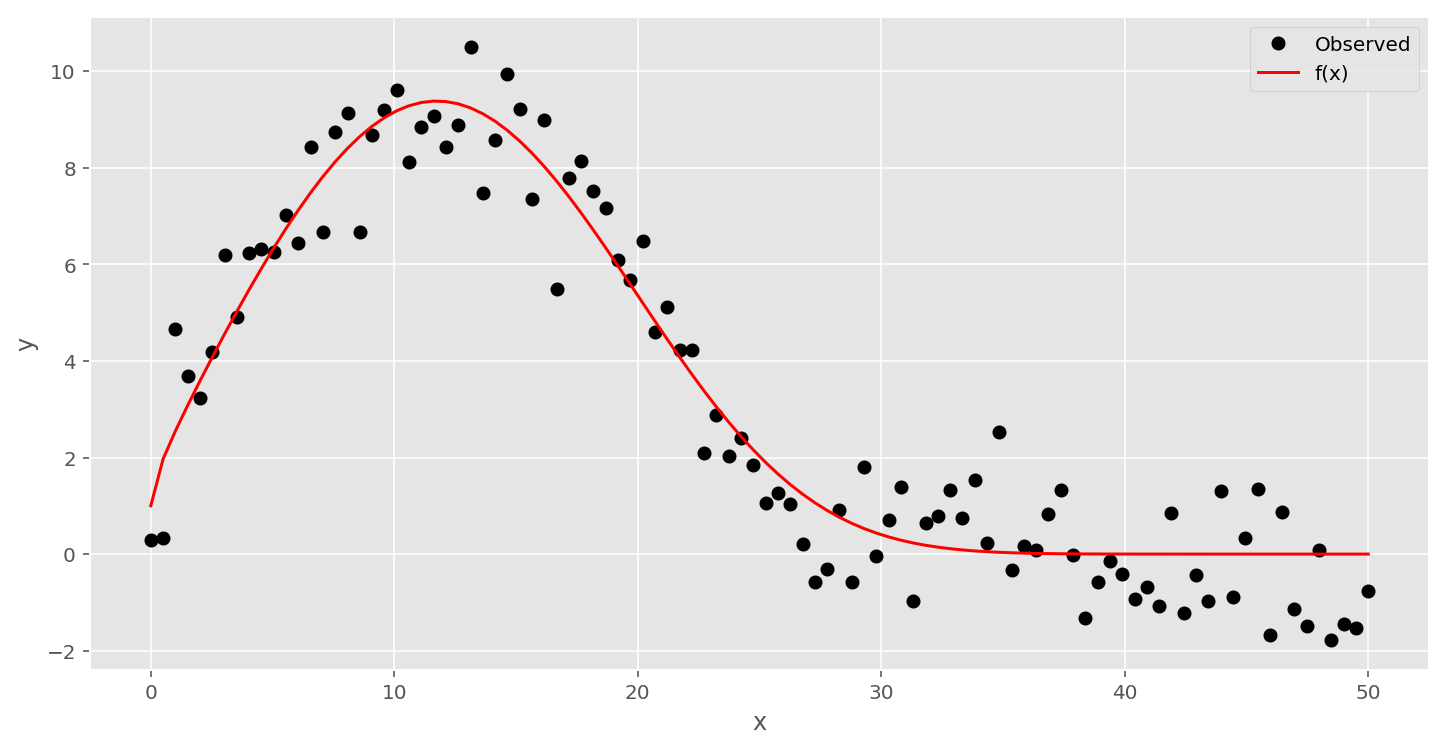

In [2]:
figsize(12, 6);

x = np.linspace(0, 50, 100)
f = np.exp(1.0 + np.power(x, 0.5) - np.exp(x/15.0))
y = f + np.random.normal(scale=1.0, size=x.shape)

plot(x, y, 'ok', label='Observed')
plot(x, f, 'r', label='f(x)')
legend()
xlabel('x');
ylabel('y');

Given only the noisy realization of $f(x)$, we want to infer the underly function. In signal processing, it could be expressed as filtering/smoothing problem: we have a **true** underlying signal, but the observation is contaminated by some noise $\epsilon$. For convinent assume $\epsilon \sim \mathcal{N}(0, \sigma^2)$, then we have $ y_i = f(x_i) + \epsilon$. Now we want to get rid of $\epsilon$.  

A easy solution is just to smoothed the data with some kernel function. It comes with many different formation: [Kernel regression](https://en.wikipedia.org/wiki/Kernel_regression), [Moving-average model](https://en.wikipedia.org/wiki/Moving-average_model), [Autoregressive model](https://en.wikipedia.org/wiki/Autoregressive_model), etc. In the most simplistic sense, the **real** value at $y_i$ is the average or weighted average of its neighbor 
$$y_i = \sum_{\substack{i-^k/_2<j<i+^k/_2}}^{k} w_j\cdot y_j  $$
$w_j$ is the weight vector with lenght $k$ and sum of 1 that centered on $y_j$.  

Similar models have been studied extensively in time-series analysis. For example, we can set up a Moving-average model with different window size.

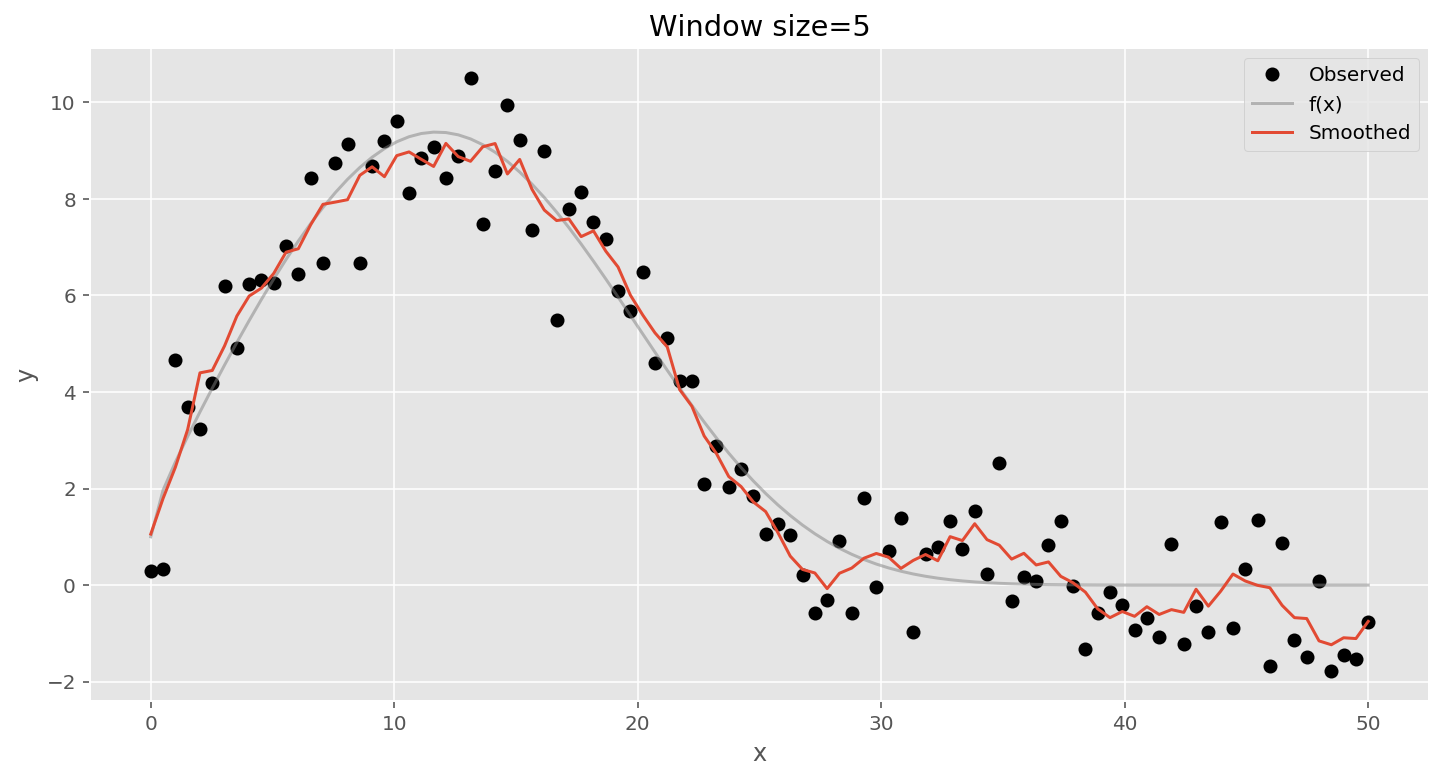

In [3]:
k = 5
moving_W = np.ones(k)/k

# Naive implementation of moving average
# y_smth = np.asarray([moving_W*y[int(i-(k-1)/2):int(i+(k-1)/2+1)] 
#                      for i in np.arange((k-1)/2, len(y)-(k-1)/2)])
# y_smth = np.hstack((y[:int((k-1)/2)], y_smth, y[int(len(y)-(k-1)/2):]))

# This is in fact a convolution
y_smth = np.convolve(y, moving_W, 'same')

plot(x, y, 'ok', label='Observed')
plot(x, f, c='gray', alpha=.5, label='f(x)')
plot(x, y_smth, label='Smoothed');
legend()
xlabel('x');
ylabel('y');
title("Window size={}".format(k));

Here, `moving_W` is usually called the kernel. Different kernel can then be apply, based on the assumption and properties of the the noise. One popular choice is a Gaussian Kernel, or a Exponentiated Quadratic Kernel, which is more self-explanatory.  

# A Bayesian Perspective of Smoothing

In time series analysis, an auto-regressive property is usually account for as one of the factor contributed to the smoothness of the realization (observation). Assumes that the observed data points are **evenly spaced** across the domain of $x$, and therefore can be indexed by $i=1,\dots,N$ without the loss of generality. The model is described as follows:

\begin{equation}
\begin{aligned}
z_1 & \sim ImproperFlat(-\infty,\infty) \\
z_i & \sim \mathcal{N}(z_{i-1} + \mu, \sigma_{1}^2) \: \text{ for } i=2,\dots,N \\
\end{aligned}
\end{equation}  

Then $z$ is a Brownian motion. If we then observed from the this latent Brownian motion, $y_i \sim \mathcal{N}(z_i,  \sigma_{2}^2)$, the total variance in the observed data $y$ is then $\sigma_{1}^2 + \sigma_{2}^2$. It implies that the total variance $\sigma^2$ of each ovservation is split between the latent Brownian motion and the noise. 

Model the total variance instead:
\begin{equation}
\begin{aligned}
z_1 & \sim ImproperFlat(-\infty,\infty) \\
z_i & \sim \mathcal{N}(z_{i-1} + \mu, (1 - \alpha)\cdot\sigma^2) \: \text{ for } i=2,\dots,N \\
y_i & \sim \mathcal{N}(z_i, \alpha\cdot\sigma^2)
\end{aligned}
\end{equation}

The ratio $\alpha = \frac{\sigma_{2}^2}{\sigma_{1}^2 + \sigma_{2}^2}, 0 < \alpha < 1$ specifying the degree of smoothing.

When we estimate the maximum likelihood values of the hidden process $z_i$ at each of the data points, $i=1,\dots,N$, these values provide an approximation of the functional dependency $y=f(x)$ as $\mathrm{E}\,[f(x_i)] = z_i$ at the original data points $x_i$ only.

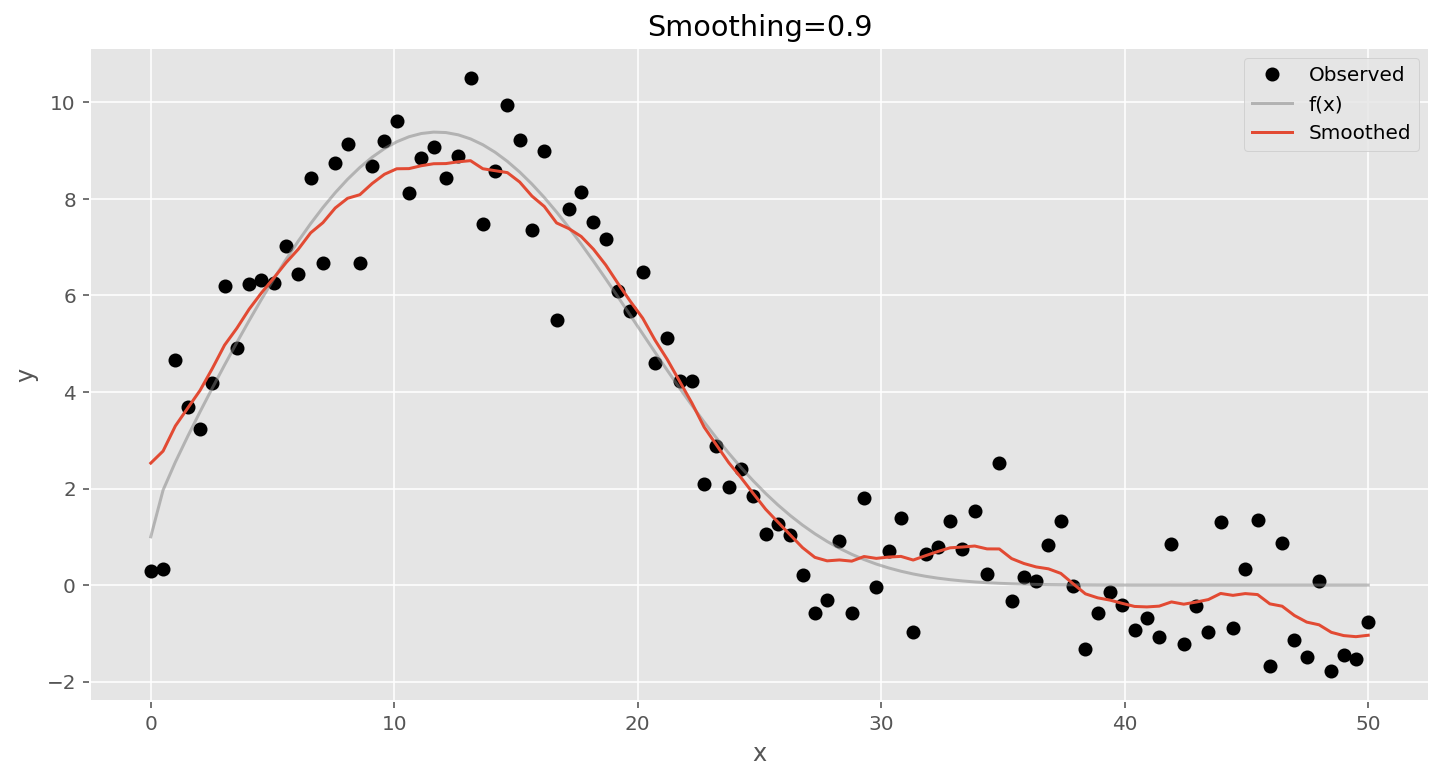

In [4]:
LARGE_NUMBER = 1e5

model = pm.Model()
with model:
    smoothing_param = shared(0.9)
    mu = pm.Normal("mu", sd=LARGE_NUMBER)
    tau = pm.Exponential("tau", 1.0/LARGE_NUMBER)
    z = GaussianRandomWalk("z",
                           mu=mu,
                           tau=tau / (1.0 - smoothing_param), 
                           shape=y.shape)
    obs = pm.Normal("obs", 
                    mu=z, 
                    tau=tau / smoothing_param, 
                    observed=y)
    
def infer_z(smoothing):
    with model:
        smoothing_param.set_value(smoothing)
        res = pm.find_MAP(vars=[z], fmin=optimize.fmin_l_bfgs_b)
        return res['z']
    
smoothing = .9
z_val = infer_z(smoothing)

plot(x, y, 'ok', label='Observed')
plot(x, f, c='gray', alpha=.5, label='f(x)')
plot(x, z_val, label='Smoothed');
legend()
xlabel('x');
ylabel('y');
title("Smoothing={}".format(smoothing));

The smoothness parameter $\alpha$ can be estimated from the data:

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -198.28: 100%|██████████| 200000/200000 [00:15<00:00, 12759.59it/s]   
Finished [100%]: Average ELBO = -198.33
100%|██████████| 3000/3000.0 [00:16<00:00, 180.99it/s]


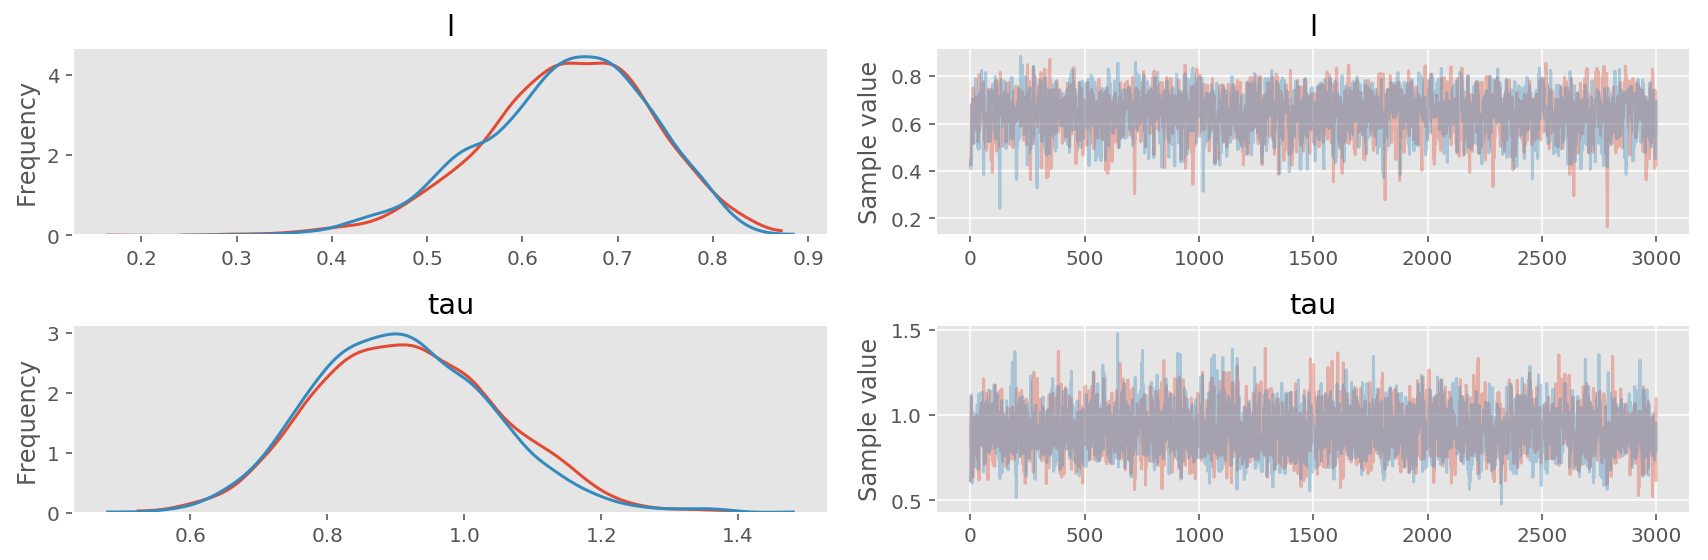

In [5]:
with pm.Model() as model2:
    smth_parm = pm.Uniform('l', lower=0, upper=1)
    mu2 = pm.Normal("mu", sd=LARGE_NUMBER)
    tau2 = pm.Exponential("tau", 1.0/LARGE_NUMBER)
    z2 = GaussianRandomWalk("z",
                           mu=mu2,
                           tau=tau2 / (1.0 - smth_parm), 
                           shape=y.shape)
    obs = pm.Normal("obs", 
                    mu=z2, 
                    tau=tau2 / smth_parm, 
                    observed=y)
    trace = pm.sample(3e3, njobs=2, tune=1000)
    
pm.traceplot(trace, varnames=['l', 'tau']);

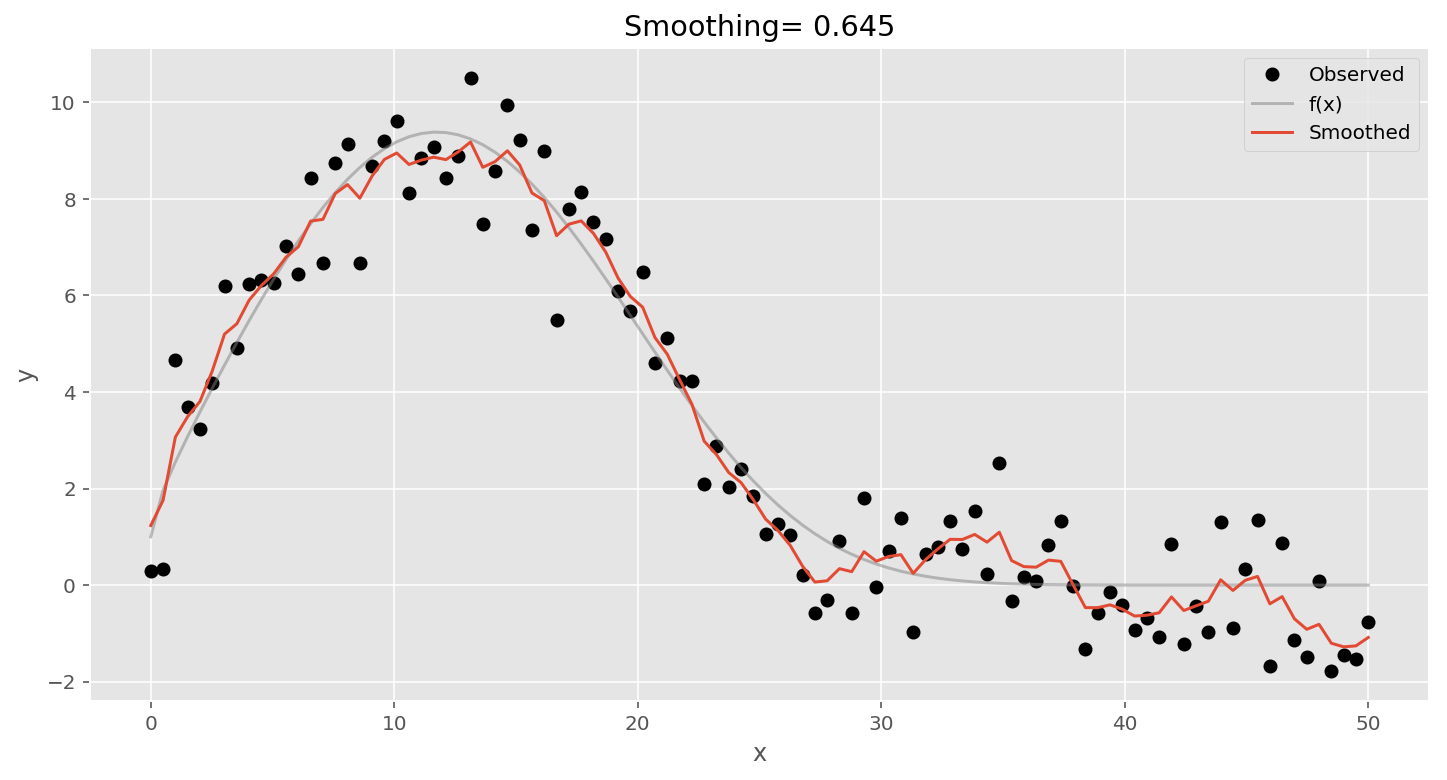

In [6]:
smoothing = np.mean(trace['l'])
z_val = infer_z(smoothing)

plot(x, y, 'ok', label='Observed')
plot(x, f, c='gray', alpha=.5, label='f(x)')
plot(x, z_val, label='Smoothed');
legend()
xlabel('x');
ylabel('y');
title('Smoothing= %.3f' % np.mean(trace['l']));

# Smoothing in Higher dimension

The following is a [Conditional Autoregressive (CAR) model](http://glau.ca/?p=340) ported from Winbugs to PyMC3.
The main motivation is to account for spatial effects throught smoothing:
$$ b_j | b_{k\neq j} \sim \mathcal{\pi}(\sum_{j \sim k} {f(b_k)}, \theta)$$
which means each data point is conditioned on other data point (spatially), and the smoothness is control by a function.

In [8]:
# setup data
county = np.array(["skye_lochalsh", "banff_buchan", "caithness,berwickshire", 
                   "ross_cromarty", "orkney", "moray", "shetland", "lochaber", 
                   "gordon", "western_isles", "sutherland", "nairn", "wigtown", 
                   "NE.fife", "kincardine", "badenoch", "ettrick", "inverness", 
                   "roxburgh", "angus", "aberdeen", "argyll_bute", "clydesdale", 
                   "kirkcaldy", "dunfermline", "nithsdale", "east_lothian", 
                   "perth_kinross", "west_lothian", "cumnock_doon", " stewartry", 
                   " midlothian", "stirling", "kyle_carrick", "inverclyde", 
                   "cunninghame", "monklands", "dumbarton", "clydebank", 
                   "renfrew", "falkirk", "clackmannan", "motherwell", "edinburgh", 
                   "kilmarnock", "east_kilbride", "hamilton", "glasgow", "dundee", 
                   "cumbernauld", "bearsden", "eastwood", "strathkelvin", "tweeddale",
                   "annandale"])

O = np.array([9, 39, 11, 9, 15, 8, 26, 7, 6, 20, 13, 5, 3, 8, 17, 9, 2, 7, 9, 7, 
              16, 31, 11, 7, 19, 15, 7, 10, 16, 11, 5, 3, 7, 8, 11, 9, 11, 8, 6, 
              4, 10, 8, 2, 6, 19, 3, 2, 3, 28, 6, 1, 1, 1, 1, 0, 0])

N = len(O)

E = np.array([1.4, 8.7, 3.0, 2.5, 4.3, 2.4, 8.1, 2.3, 2.0, 6.6, 4.4, 1.8, 1.1, 
              3.3, 7.8, 4.6, 1.1, 4.2, 5.5, 4.4, 10.5, 22.7, 8.8, 5.6, 15.5, 
              12.5, 6.0, 9.0, 14.4, 10.2, 4.8, 2.9, 7.0, 8.5, 12.3, 10.1, 12.7, 
              9.4, 7.2, 5.3, 18.8, 15.8, 4.3, 14.6, 50.7, 8.2, 5.6, 9.3, 88.7, 
              19.6, 3.4, 3.6, 5.7, 7.0, 4.2, 1.8])

logE = np.log(E)

aff = np.array([16, 16, 10, 24, 10, 24, 10, 7, 7, 16, 7, 16, 10, 24, 7, 16, 10, 
                7, 7, 10, 7, 16, 10, 7, 1, 1, 7, 7, 10, 10, 7, 24, 10, 7, 7, 0, 
                10, 1, 16, 0, 1, 16, 16, 0, 1, 7, 1, 1, 0, 1, 1, 0, 1, 1, 16, 10])/10.

num = np.array([4, 2, 2, 3, 5, 2, 5, 1,  6, 4, 4, 3, 4, 3, 3, 6, 6, 6 ,5, 3, 3, 
                2, 6, 8, 3, 4, 4, 4,11,  6, 7, 4, 4, 9, 5, 4, 5, 6, 5, 5, 7, 6, 
                4, 5, 4, 6, 6, 4, 9, 3, 4, 4, 4, 5, 5, 6])

adj = np.array([[5, 9,11,19],
[7,10],
[6,12],
[18,20,28],
[1,11,12,13,19],
[3, 8],
[2,10,13,16,17],
[6],
[1,11,17,19,23,29],
[2, 7,16,22],
[1, 5, 9,12],
[3, 5,11],
[5, 7,17,19],
[31,32,35],
[25,29,50],
[7,10,17,21,22,29],
[7, 9,13,16,19,29],
[4,20,28,33,55,56],
[1, 5, 9,13,17],
[4,18,55],
[16,29,50],
[10,16],
[9,29,34,36,37,39],
[27,30,31,44,47,48,55,56],
[15,26,29],
[25,29,42,43],
[24,31,32,55],
[4,18,33,45],
[9,15,16,17,21,23,25,26,34,43,50],
[24,38,42,44,45,56],
[14,24,27,32,35,46,47],
[14,27,31,35],
[18,28,45,56],
[23,29,39,40,42,43,51,52,54],
[14,31,32,37,46],
[23,37,39,41],
[23,35,36,41,46],
[30,42,44,49,51,54],
[23,34,36,40,41],
[34,39,41,49,52],
[36,37,39,40,46,49,53],
[26,30,34,38,43,51],
[26,29,34,42],
[24,30,38,48,49],
[28,30,33,56],
[31,35,37,41,47,53],
[24,31,46,48,49,53],
[24,44,47,49],
[38,40,41,44,47,48,52,53,54],
[15,21,29],
[34,38,42,54],
[34,40,49,54],
[41,46,47,49],
[34,38,49,51,52],
[18,20,24,27,56],
[18,24,30,33,45,55]])

# Change to Python indexing (i.e. -1)
for i in range(len(adj)):
    for j in range(len(adj[i])):
        adj[i][j] = adj[i][j]-1


weights = np.array([[1,1,1,1],
[1,1],
[1,1],
[1,1,1],
[1,1,1,1,1],
[1, 1],
[1,1,1,1,1],
[1],
[1,1,1,1,1,1],
[1, 1,1,1],
[1, 1, 1,1],
[1, 1,1],
[1, 1,1,1],
[1,1,1],
[1,1,1],
[1,1,1,1,1,1],
[1, 1,1,1,1,1],
[1,1,1,1,1,1],
[1, 1, 1,1,1],
[1,1,1],
[1,1,1],
[1,1],
[1,1,1,1,1,1],
[1,1,1,1,1,1,1,1],
[1,1,1],
[1,1,1,1],
[1,1,1,1],
[1,1,1,1],
[1,1,1,1,1,1,1,1,1,1,1],
[1,1,1,1,1,1],
[1,1,1,1,1,1,1],
[1,1,1,1],
[1,1,1,1],
[1,1,1,1,1,1,1,1,1],
[1,1,1,1,1],
[1,1,1,1],
[1,1,1,1,1],
[1,1,1,1,1,1],
[1,1,1,1,1],
[1,1,1,1,1],
[1,1,1,1,1,1,1],
[1,1,1,1,1,1],
[1,1,1,1],
[1,1,1,1,1],
[1,1,1,1],
[1,1,1,1,1,1],
[1,1,1,1,1,1],
[1,1,1,1],
[1,1,1,1,1,1,1,1,1],
[1,1,1],
[1,1,1,1],
[1,1,1,1],
[1,1,1,1],
[1,1,1,1,1],
[1,1,1,1,1],
[1,1,1,1,1,1]])

Wplus = np.asarray([sum(w) for w in weights])

WinBugs model:
```
model
{
   for (i in 1 : regions) {
      O[i] ~ dpois(mu[i])
      log(mu[i]) <- log(E[i]) + beta0 + beta1*aff[i]/10 + phi[i] + theta[i]
      theta[i] ~ dnorm(0.0,tau.h)
   }
   phi[1:regions] ~ car.normal(adj[], weights[], num[], tau.c)

   beta0 ~ dnorm(0.0, 1.0E-5)  # vague prior on grand intercept
   beta1 ~ dnorm(0.0, 1.0E-5)  # vague prior on covariate effect

   tau.h ~ dgamma(3.2761, 1.81)    
   tau.c ~ dgamma(1.0, 1.0)  

   sd.h <- sd(theta[]) # marginal SD of heterogeneity effects
   sd.c <- sd(phi[])   # marginal SD of clustering (spatial) effects

   alpha <- sd.c / (sd.h + sd.c)
}
```

In [10]:
# Setup the function for the spatial smooth effect
import theano
import theano.tensor as tt
floatX = "float32"

value=np.asarray(np.random.randn(100,), dtype=theano.config.floatX)

maxwz = max([sum(w) for w in weights])
N = len(weights)
wmat = np.zeros((N, maxwz))
amat = np.zeros((N, maxwz), dtype=int32)
for i, w in enumerate(weights):
    wmat[i, np.arange(len(w))] = w
    amat[i, np.arange(len(w))] = adj[i]

# defining the tensor variables
x = tt.vector("x")
x.tag.test_value = value
w = tt.matrix("w")
# provide Theano with a default test-value
w.tag.test_value = wmat
a = tt.matrix("a", dtype='int32')
a.tag.test_value = amat


def get_mu(w, a):
    a1 = tt.cast(a, 'int32')
    return tt.sum(w*x[a1])/tt.sum(w)

results, _ = theano.scan(fn=get_mu, sequences=[w, a])
compute_elementwise = theano.function(inputs=[x, w, a], outputs=results)

print(compute_elementwise(value, wmat, amat))

def mu_phi(value):
    N=len(weights)
    # Calculate mu based on average of neighbours 
    mu = np.array([np.sum(weights[i]*value[adj[i]])/Wplus[i] for i in range(N)])
    return mu

print(mu_phi(value))

[ -1.40312489e-01  -9.00324623e-01  -3.45734621e-01  -2.95991740e-01
  -5.22916486e-01   4.00634433e-02  -1.07639002e+00  -7.69170750e-01
  -3.43635824e-01  -1.46301265e-01  -2.31059436e-01  -4.64119728e-01
  -3.97219782e-01   2.50503335e-01  -2.06742727e-01  -7.62644880e-01
  -3.27730518e-01  -5.53400888e-01  -7.15687569e-01   4.64494984e-01
  -7.30035853e-01  -1.63908499e+00  -3.82092911e-01   3.65688388e-02
   1.50215240e-01  -5.16861744e-01   3.42155605e-02  -4.79393137e-01
  -2.19164842e-01  -1.24061400e+00  -1.20015354e-01   1.04597984e-01
  -4.15146586e-01  -6.96880279e-01  -4.74466705e-03  -5.16684686e-02
  -9.13116752e-02  -5.18168423e-01  -2.38604744e-01  -1.51396505e-01
  -3.63078753e-01  -9.82627582e-01  -7.40763181e-01  -6.41545367e-01
  -9.99752010e-01  -5.61699329e-04  -3.05092459e-01   1.83660073e-03
  -4.90835970e-01  -1.28906716e-01  -1.25722912e+00   9.24662134e-02
   3.39570658e-01  -9.01635354e-01  -1.73911914e-01  -3.99753361e-01]
[ -1.40312489e-01  -9.00324623e-0

In [11]:
# setup the CAR distribution
import pymc3 as pm
import theano.tensor as tt
from theano import scan
import theano
floatX = "float32"

from pymc3.distributions import continuous
from pymc3.distributions import distribution

class CAR(distribution.Continuous):
    """
    Conditional Autoregressive (CAR) distribution
    
    Parameters
    ----------
    k : tensor
       effect of lagged value on current value
    tau_e : tensor
       precision for innovations
    """

    def __init__(self, w, a, tau, *args, **kwargs):
        super(CAR, self).__init__(*args, **kwargs)
        self.a = a = tt.as_tensor_variable(a)
        self.w = w = tt.as_tensor_variable(w)
        self.tau = tau*tt.sum(w, axis=1)
        self.mode = 0.
    
    def get_mu(self, x):
        
        def weigth_mu(w, a):
            a1 = tt.cast(a, 'int32')
            return tt.sum(w*x[a1])/tt.sum(w)

        mu_w, _ = scan(fn=weigth_mu, 
                       sequences=[self.w, self.a])
        
        return mu_w
    
    def logp(self, x):
        mu_w = self.get_mu(x)
        tau = self.tau
        return tt.sum(continuous.Normal.dist(mu=mu_w, tau=tau).logp(x))

In [12]:
with pm.Model() as model:
    # Vague prior on intercept
    beta0 = pm.Normal('beta0', mu=0.0, tau=1.0e-5)
    # Vague prior on covariate effect
    beta1 = pm.Normal('beta1', mu=0.0, tau=1.0e-5)

    # Random effects (hierarchial) prior
    tau_h = pm.Gamma('tau_h', alpha=3.2761, beta=1.81)
    # Spatial clustering prior
    tau_c = pm.Gamma('tau_c', alpha=1.0, beta=1.0)

    # Regional random effects
    theta = pm.Normal('theta', mu=0.0, tau=tau_h, shape=N)
    
    mu_phi = CAR('mu_phi', w=wmat, a=amat, tau=tau_c, shape=N)

    # Zero-centre phi
    phi = pm.Deterministic('phi', mu_phi-tt.mean(mu_phi))

    # Mean model
    mu = pm.Deterministic('mu', tt.exp(logE + beta0 + beta1*aff + theta + phi))

    # Likelihood
    Yi = pm.Poisson('Yi', mu=mu, observed=O)

    # Marginal SD of heterogeniety effects
    sd_h = pm.Deterministic('sd_h', tt.std(theta))
    # Marginal SD of clustering (spatial) effects
    sd_c = pm.Deterministic('sd_c', tt.std(phi))
    # Proportion spatial variance
    alpha = pm.Deterministic('alpha', sd_c/(sd_h+sd_c))
    
    trace = pm.sample(3e3, njobs=2, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -191.47: 100%|██████████| 200000/200000 [02:12<00:00, 1510.12it/s]
Finished [100%]: Average ELBO = -191.54
100%|██████████| 3000/3000.0 [06:28<00:00,  7.72it/s]


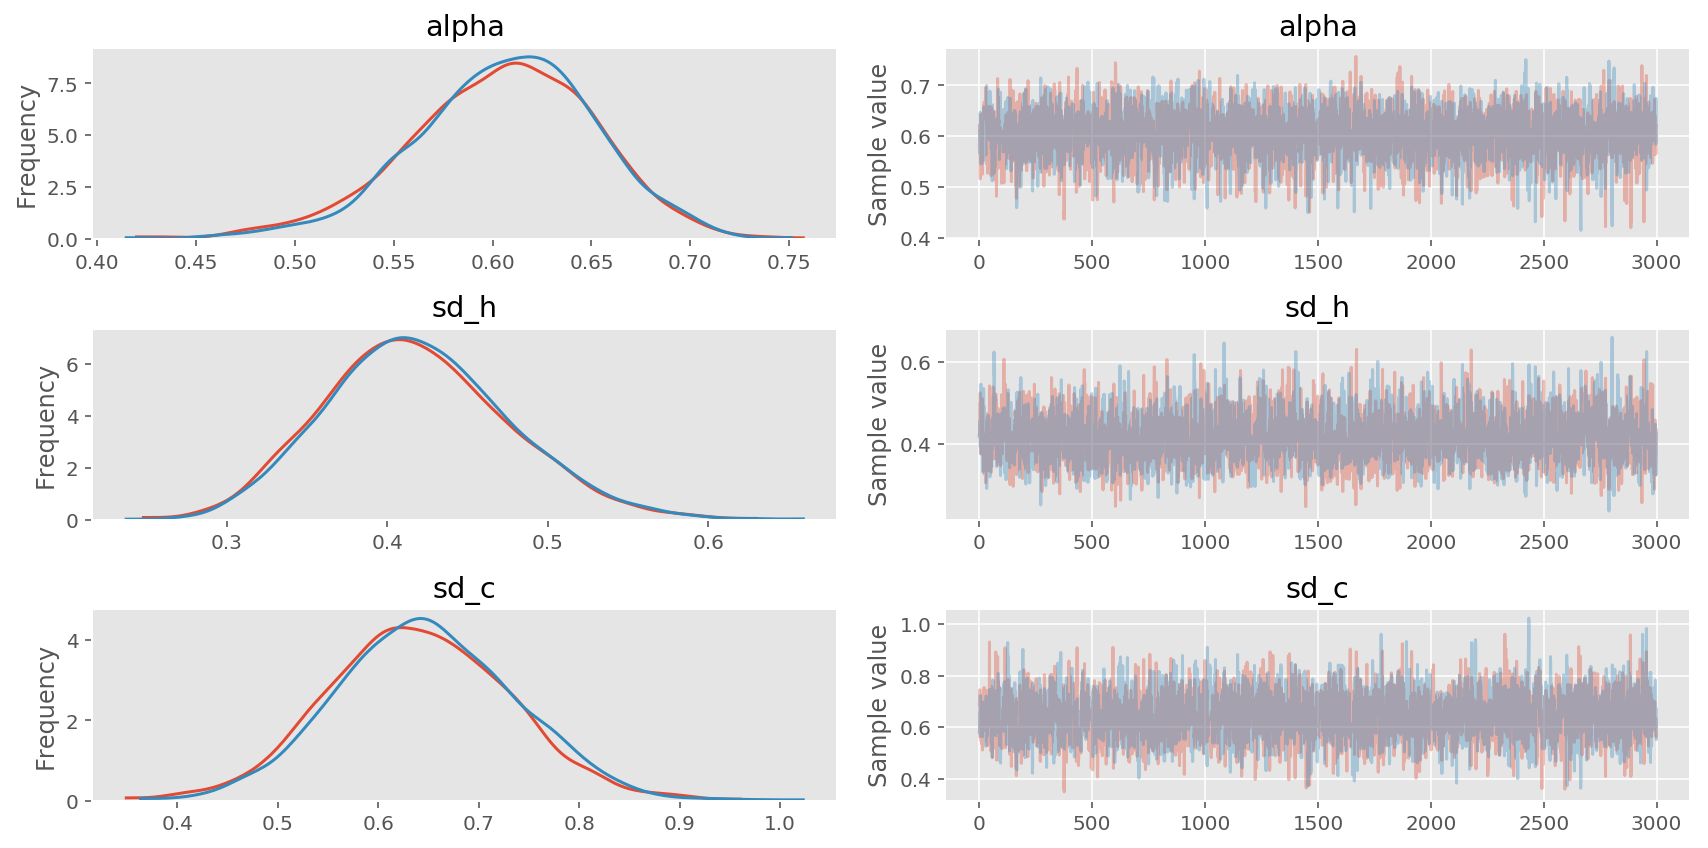

In [13]:
pm.traceplot(trace, varnames=['alpha', 'sd_h', 'sd_c']);

We can not inference on the spatial smoothness effect $\alpha$

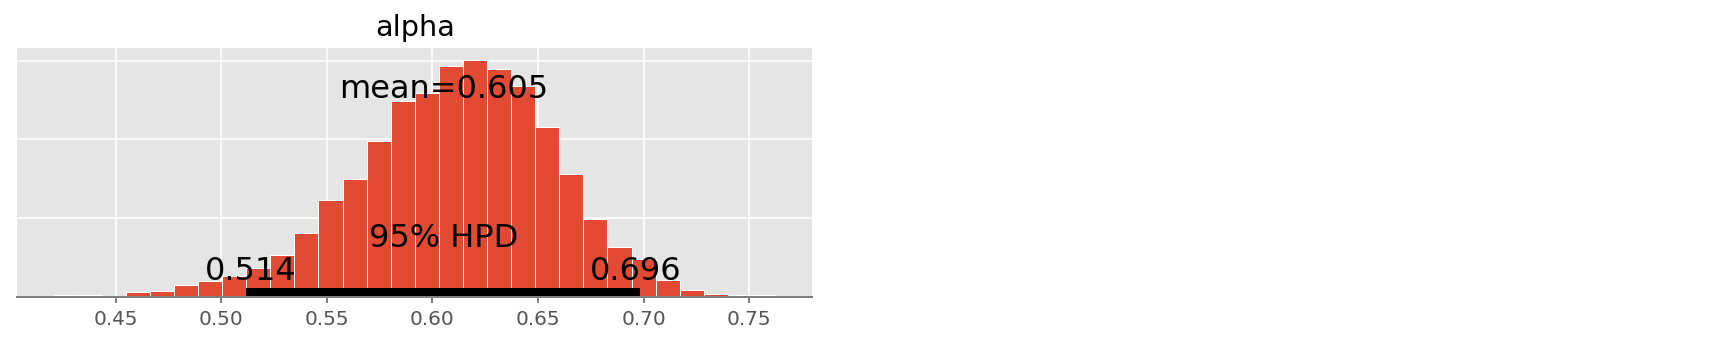

In [14]:
pm.posteriorplot(trace, varnames=['alpha']);

With some matrix trick, the above model can be further improved.

In [15]:
maxwz = max([sum(w) for w in weights])
N = len(weights)
wmat2 = np.zeros((N, N))
amat2 = np.zeros((N, N), dtype=int32)
for i, a in enumerate(adj):
    amat2[i, a] = 1
    wmat2[i, a] = weights[i]
    
value=np.asarray(np.random.randn(N,), dtype=theano.config.floatX)

print(np.sum(value*amat2, axis=1)/np.sum(wmat2, axis=1))

def mu_phi(value):
    N=len(weights)
    # Calculate mu based on average of neighbours 
    mu = np.array([np.sum(weights[i]*value[adj[i]])/Wplus[i] for i in range(N)])
    return mu

print(mu_phi(value))

[-0.64056244  0.21096148  0.36537676 -0.60222988 -0.33619429 -0.50689927
  0.12479542  0.08074948 -0.11983116 -0.22314843 -0.0744245  -1.37700315
 -0.42449346 -0.32672728 -0.05417601 -0.2440875   0.21594207 -0.34744122
 -0.24632565  0.49031411  0.04581728  0.94252224  0.35659716 -0.03158557
  0.01704923 -0.2512019   0.23712041 -0.18395699  0.14500702  0.13088614
 -0.04902179 -0.21691862 -0.15701423 -0.46865326 -0.21000651  0.67279205
  0.43871553 -0.48668856  0.15332206 -0.17753242  0.18832568 -0.37315228
 -0.05228038  0.72226987 -0.23745077  0.31319346  0.75972885  0.32829932
 -0.03477451 -0.45486347 -0.30127059 -0.47023379 -0.36539744 -0.48838059
  0.1200328   0.06165597]
[-0.64056244  0.21096148  0.36537676 -0.60222988 -0.33619429 -0.50689927
  0.12479542  0.08074948 -0.11983116 -0.22314843 -0.0744245  -1.37700315
 -0.42449346 -0.32672728 -0.05417601 -0.2440875   0.21594207 -0.34744122
 -0.24632565  0.49031411  0.04581728  0.94252224  0.35659716 -0.03158557
  0.01704923 -0.2512019  

In [16]:
import pymc3 as pm
import theano.tensor as tt
from theano import scan
import theano
floatX = "float32"

from pymc3.distributions import continuous
from pymc3.distributions import distribution

class CAR2(distribution.Continuous):
    """
    Conditional Autoregressive (CAR) distribution
    
    Parameters
    ----------
    k : tensor
       effect of lagged value on current value
    tau_e : tensor
       precision for innovations
    """

    def __init__(self, w, a, tau, *args, **kwargs):
        super(CAR2, self).__init__(*args, **kwargs)
        self.a = a = tt.as_tensor_variable(a)
        self.w = w = tt.as_tensor_variable(w)
        self.tau = tau*tt.sum(w, axis=1)
        self.mode = 0.
    
    def logp(self, x):
        tau = self.tau
        w = self.w
        a = self.a
        
        mu_w = tt.sum(x*a, axis=1)/tt.sum(w, axis=1)
        return tt.sum(continuous.Normal.dist(mu=mu_w, tau=tau).logp(x))

In [17]:
with pm.Model() as model:
    # Vague prior on intercept
    beta0 = pm.Normal('beta0', mu=0.0, tau=1.0e-5)
    # Vague prior on covariate effect
    beta1 = pm.Normal('beta1', mu=0.0, tau=1.0e-5)

    # Random effects (hierarchial) prior
    tau_h = pm.Gamma('tau_h', alpha=3.2761, beta=1.81)
    # Spatial clustering prior
    tau_c = pm.Gamma('tau_c', alpha=1.0, beta=1.0)

    # Regional random effects
    theta = pm.Normal('theta', mu=0.0, tau=tau_h, shape=N)
    
    mu_phi = CAR2('mu_phi', w=wmat2, a=amat2, tau=tau_c, shape=N)

    # Zero-centre phi
    phi = pm.Deterministic('phi', mu_phi-tt.mean(mu_phi))

    # Mean model
    mu = pm.Deterministic('mu', tt.exp(logE + beta0 + beta1*aff + theta + phi))

    # Likelihood
    Yi = pm.Poisson('Yi', mu=mu, observed=O)

    # Marginal SD of heterogeniety effects
    sd_h = pm.Deterministic('sd_h', tt.std(theta))
    # Marginal SD of clustering (spatial) effects
    sd_c = pm.Deterministic('sd_c', tt.std(phi))
    # Proportion sptial variance
    alpha = pm.Deterministic('alpha', sd_c/(sd_h+sd_c))
    
    trace = pm.sample(3e3, njobs=2, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -191.47: 100%|██████████| 200000/200000 [00:22<00:00, 8706.46it/s]
Finished [100%]: Average ELBO = -191.54
100%|██████████| 3000/3000.0 [01:07<00:00, 44.36it/s]


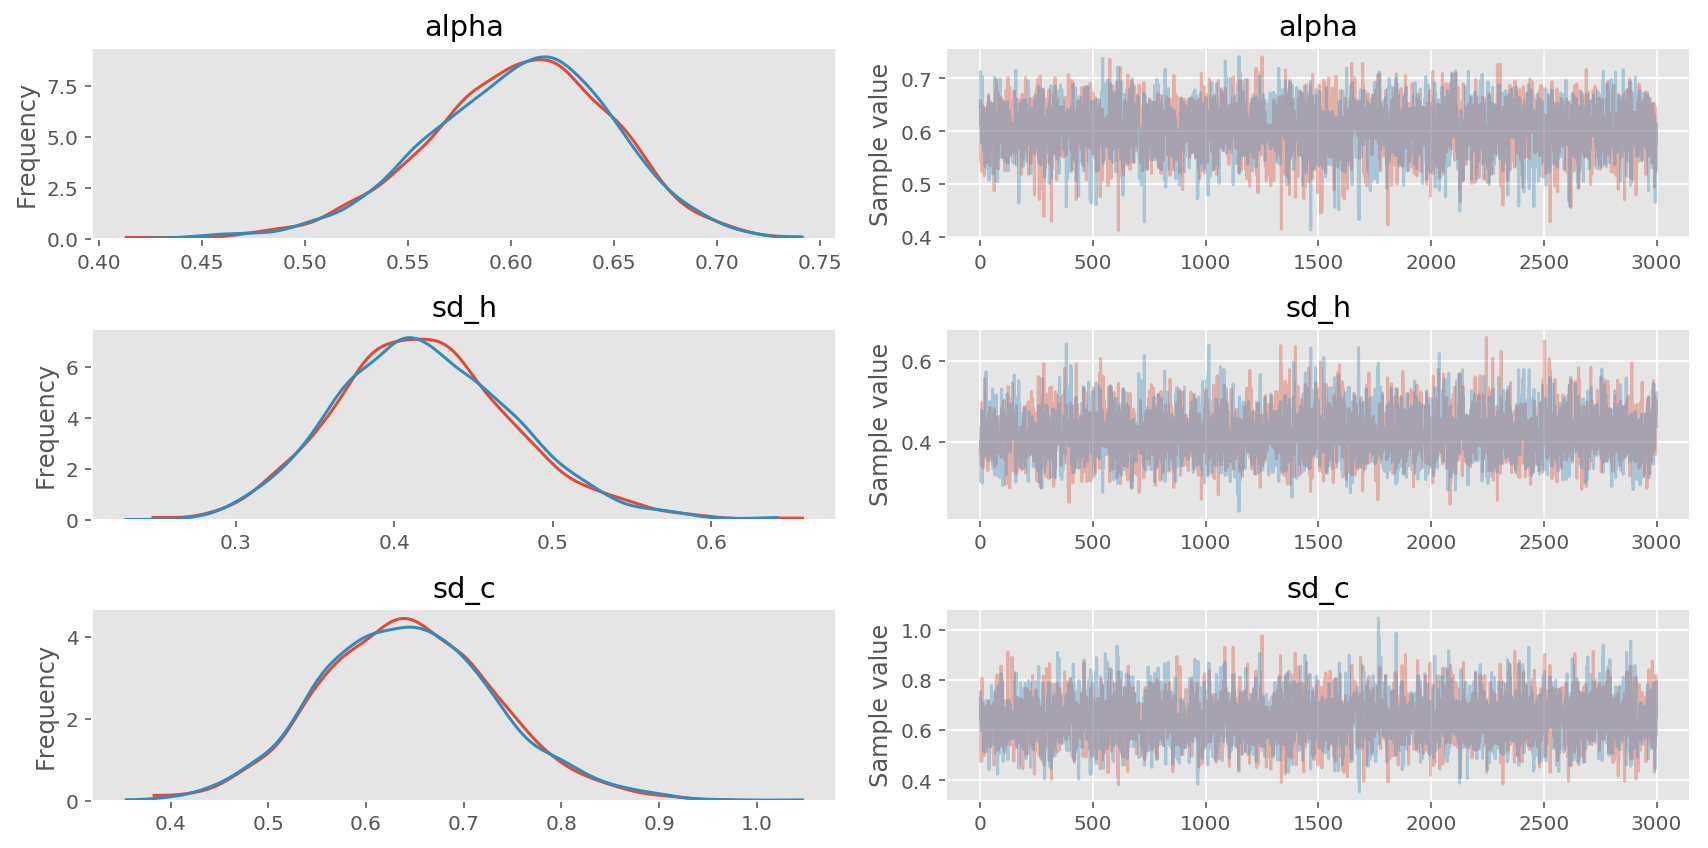

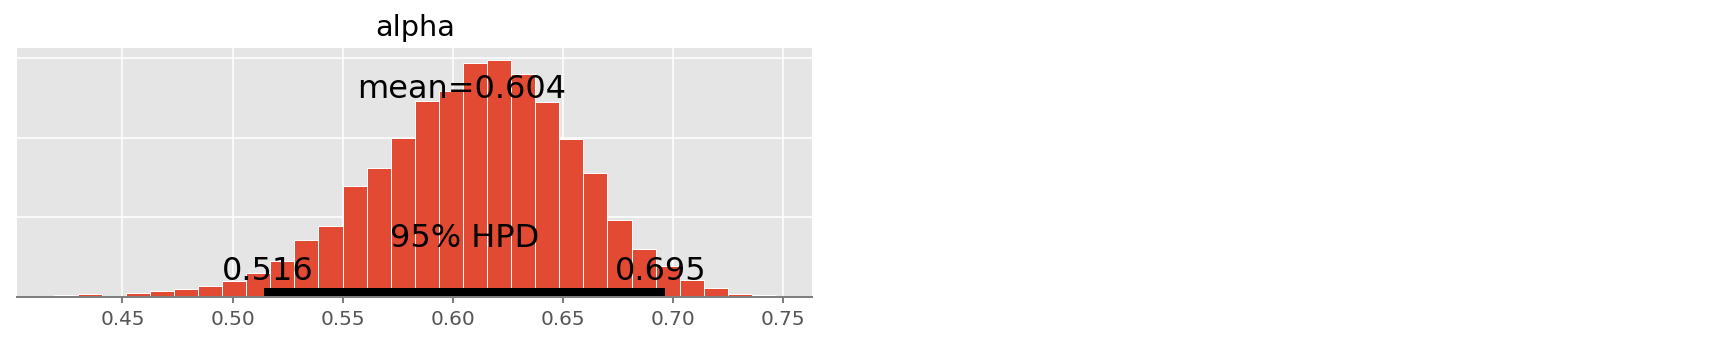

In [18]:
pm.traceplot(trace, varnames=['alpha', 'sd_h', 'sd_c']);
pm.posteriorplot(trace, varnames=['alpha']);